In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [3]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

### Feature Vectors 

The available feature descriptors are:

- `has_face` that indicates if a **face** is present in the album cover
- `hog_descriptor` that focuses on the **structure** of the image 
- `hsv_hist` that quantifies the **color**
- `lbp_hist` that quantifies the **texture**

**Combining Feature Vectors**

For global feature vectors, we concatenate each feature vector to form a single global feature vector. This approach used in this notebook.


In [4]:
fv_has_face = albums_df.has_face
fv_hog_desc = albums_df.hog_descriptor
fv_hsv_hist = albums_df.hsv_hist
fv_lbp_hist = albums_df.lbp_hist

In [65]:
global_feature =[]

for index in albums_df.index:
    feature_vector = np.hstack([fv_hog_desc[index], fv_hsv_hist[index] ])
    global_feature.append(feature_vector)
    
# scaler = MinMaxScaler(feature_range=(0, 1))    
# X = scaler.fit_transform(feature)

albums_df['X'] = global_feature

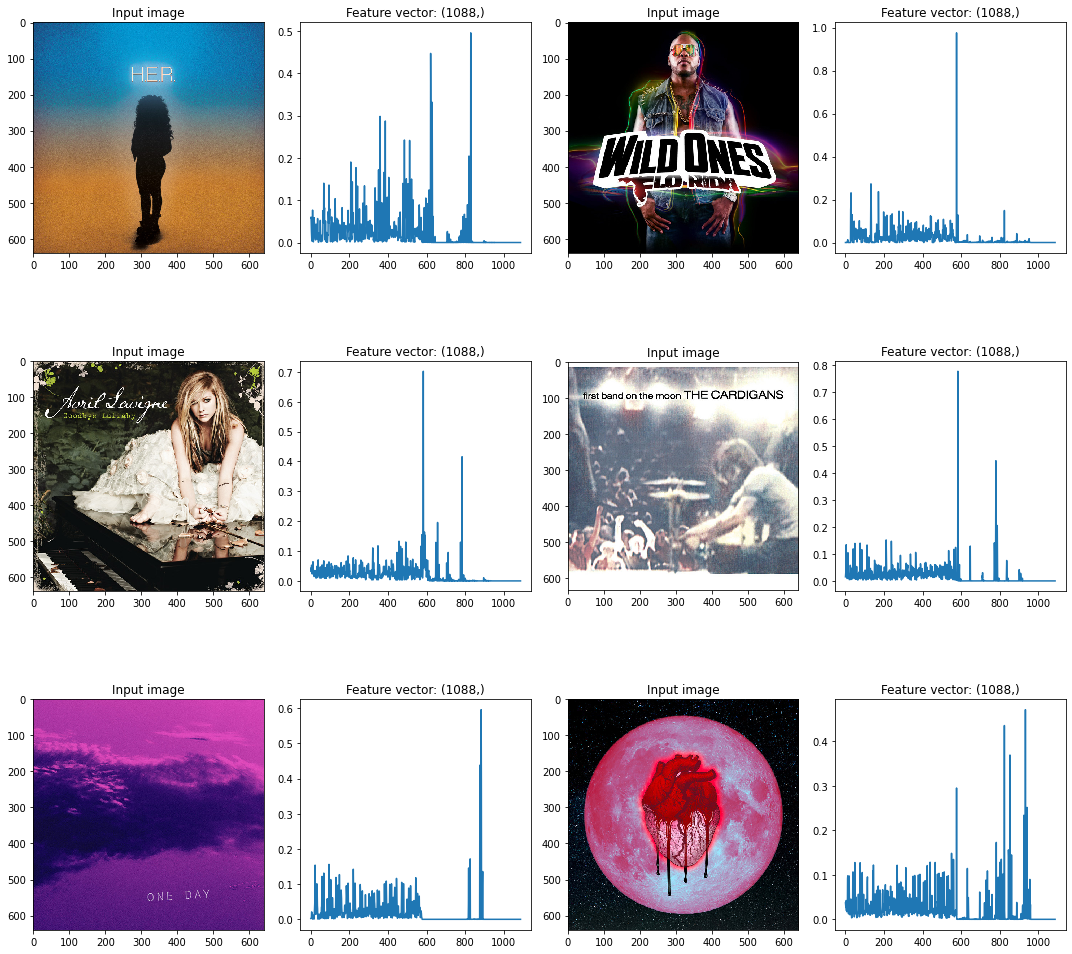

In [66]:
from skimage.io import imread, imshow

image_samples = albums_df.filepath.sample(n = 6, random_state = 42) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
hog_no = 0

for plot_number, filepath in enumerate(image_samples):
    image = imread(filepath)
     
    
    ax1 = fig.add_subplot(rows, columns, plot_number+hog_no+1,)
    imshow(image )
    ax1.set_title('Input image') 
    
    ax2 = fig.add_subplot(rows, columns, plot_number+hog_no+2,)
    plt.plot(albums_df[albums_df.filepath == filepath].X.values[0])
    asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    ax2.set_title(f"Feature vector: ({albums_df[albums_df.filepath == filepath].X.values[0].size},)")
    
    hog_no+=1
    
plt.show()

### Split the Dataset

In [19]:
from sklearn.model_selection import train_test_split

y = np.array(albums_df['rock'])

X = albums_df.X 

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=22,
)

X_TRAIN = X_train
X_TEST = X_test

In [643]:
np.unique(y_test, return_counts=True), np.unique(y_train, return_counts=True)

((array([0, 1], dtype=int64), array([266,  53], dtype=int64)),
 (array([0, 1], dtype=int64), array([1027,  246], dtype=int64)))

In [20]:
def transform(X):
    return np.array([x for x in X] )

X_train = transform(X_train)
X_test = transform(X_test)

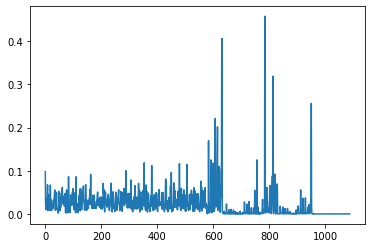

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# X_train_prepared = StandardScaler().fit_transform(X_train)
# X_test_prepared = StandardScaler().fit_transform(X_test)

#Normalize The feature vectors...
# scaler = MinMaxScaler(feature_range=(0, 1))

 
# X_train_prepared = scaler.fit_transform(X_train)
# X_test_prepared = scaler.fit_transform(X_test)

X_train_prepared = X_train
X_test_prepared = X_test


plt.plot(X_train_prepared[1070])

In [520]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter = 1000, C=50).fit(X_train_prepared, y_train)

In [521]:
clf.score(X_train_prepared, y_train)

0.8413197172034564

In [72]:
y_pred = clf.predict(X_train_prepared)

np.unique((abs(y_train-y_pred)), return_counts=True)

(array([0, 1], dtype=int64), array([1264,    9], dtype=int64))

In [73]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from skimage.io import imread, imshow

In [681]:
# create all the machine learning models
seed = 22
num_trees = 100
scoring    = "accuracy"
# variables to hold the results and names
results = []
names   = []

models = []
models.append(('LR', LogisticRegression(random_state=seed, max_iter = 1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))

In [682]:
# 10-fold cross validation
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_prepared, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.805192 (0.007486)
KNN: 0.781638 (0.014489)
CART: 0.681072 (0.034838)
RF: 0.809904 (0.007497)
NB: 0.443855 (0.027573)
SVM: 0.806761 (0.003531)


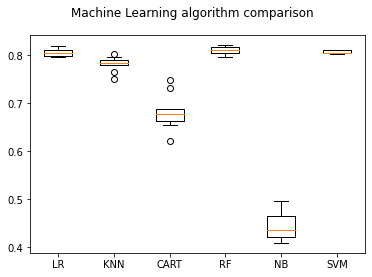

In [683]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [634]:
clf_pop = RandomForestClassifier(n_estimators=25, random_state=seed).fit(X_train_prepared, y_train)

In [641]:
clf_rap = RandomForestClassifier(n_estimators=25, random_state=seed).fit(X_train_prepared, y_train)

In [711]:
clf_rock = RandomForestClassifier(max_features = 200, n_estimators=100, random_state=seed).fit(X_train_prepared, y_train)

In [623]:
#clf = LogisticRegression(random_state=seed, max_iter = 1000, C =50).fit(X_train_prepared, y_train)
#clf = SVC(random_state=seed, kernel='linear', C=20).fit(X_train_prepared, y_train)
clf = RandomForestClassifier(n_estimators=100, random_state=seed).fit(X_train_prepared, y_train)

y_pred = clf.predict(X_train_prepared)

confusion_matrix(y_train, y_pred)

tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
tn, fp, fn, tp

(686, 0, 1, 586)

In [624]:
y_pred = clf.predict(X_train_prepared)
confusion_matrix(y_train, y_pred)

array([[686,   0],
       [  1, 586]], dtype=int64)

In [712]:
y_pred = clf_rock.predict(X_test_prepared)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(266, 0, 49, 4)

In [713]:
confusion_matrix(y_test, y_pred)

array([[266,   0],
       [ 49,   4]], dtype=int64)

In [480]:
from fd_functions import fd_hog_descriptor, fd_hsv_histogram, fd_local_binary_pattern
from skimage.io import imread, imshow

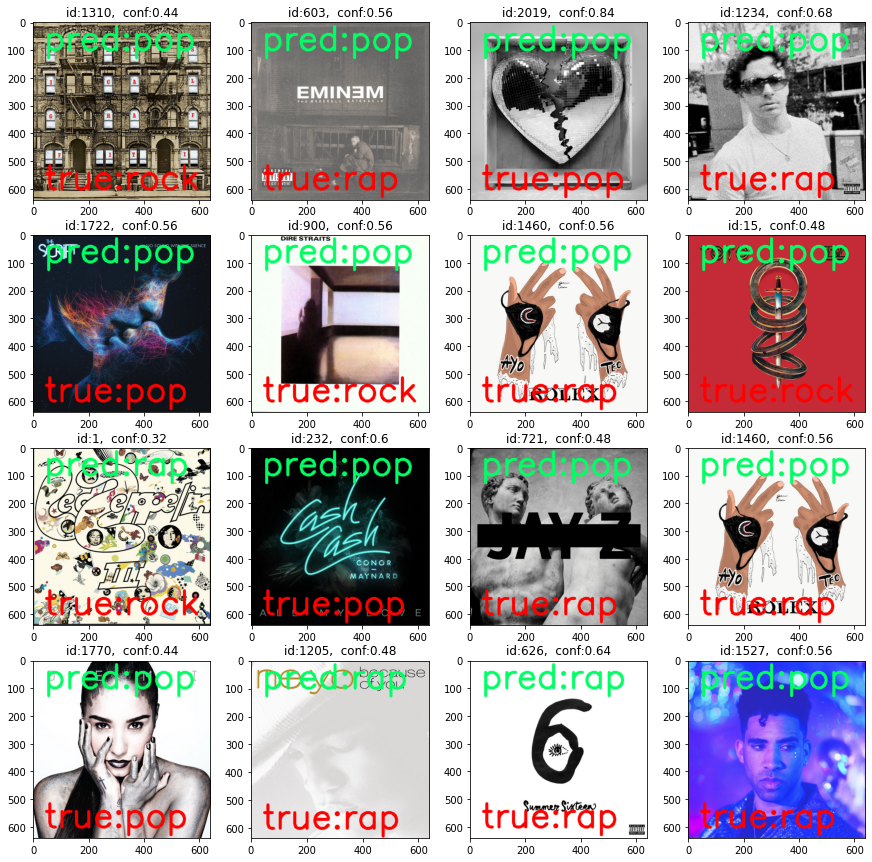

In [678]:
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 4

for i in range(16):
    
    index = X_TEST.sample().index[0]
#     albums_df.sample(random_state=32).index[0]
    filepath = albums_df.filepath[index]
    
    image = cv2.imread(filepath)
    fv_2 = fd_hsv_histogram(image)
    
    
    image = imread(filepath)
    fv_1 = fd_hog_descriptor(image)
    
    image = cv2.imread(filepath)
    

        
    _X = np.array(np.append(fv_1,fv_2))
#     _X = scaler.transform([_X])
 
    
    train_labels = {1: 'rap', 0:'n/a'}

    prediction_pop = clf_pop.predict_proba([_X])[:,1][0]
    prediction_rap = clf_rap.predict_proba([_X])[:,1][0]
    prediction_rock = clf_rock.predict_proba([_X])[:,1][0]
    
    prediction = pd.Series([prediction_pop  , prediction_rap  , prediction_rock], ['pop','rap', 'rock'] )

    cv2.putText(image, "pred:" + prediction.idxmax() , (40,100), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (100,255,0), 9)
    cv2.putText(image, "true:" + albums_df.genres[index][0], (40,600), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (0,0,255), 9)
    
    
#     # # show predicted label on image
#     if prediction:
#         cv2.putText(image, "pred:" + prediction.idxmax() , (40,100), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (100,255,0), 9)
#         cv2.putText(image, "true:" + albums_df.genres[index][0], (40,600), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (0,0,255), 9)
#     else:
#         cv2.putText(image, "true:" + albums_df.genres[index][0], (40,600), cv2.FONT_HERSHEY_SIMPLEX, 4.0, (0,0,255), 9)
        

    ax1 = fig.add_subplot(rows, columns, i + 1,)
    ax1.set_title(f"id:{index},  conf:{prediction.max()}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


plt.show()

In [307]:
import sys
np.set_printoptions(threshold=50)

Text(0.5, 1.0, 'confidence:0.68')

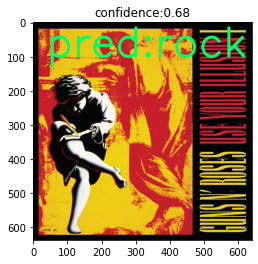

In [697]:
filepath = '.\\images\\5PpakQQKMNd2ayVRi4sI0B.jpg'
filepath = '.\\rock2.jpg'    

image = cv2.imread(filepath)
fv_2 = fd_hsv_histogram(image)


image = imread(filepath)
fv_1 = fd_hog_descriptor(image)

image = cv2.imread(filepath)

 
X = np.array(np.append(fv_1,fv_2 ))
 

train_labels = {1: 'pop', 0:'n/a'}

prediction_pop = clf_pop.predict_proba([X])[:,1][0]
prediction_rap = clf_rap.predict_proba([X])[:,1][0]
prediction_rock = clf_rock.predict_proba([X])[:,1][0]
    
prediction = pd.Series([prediction_pop  , prediction_rap  , prediction_rock], ['pop','rap', 'rock'] )

cv2.putText(image, "pred:" + prediction.idxmax() , (40,100), cv2.FONT_HERSHEY_SIMPLEX, 4, (100,255,0), 8)
 

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"confidence:{prediction.max()}")



0
884


0.022226423490601686

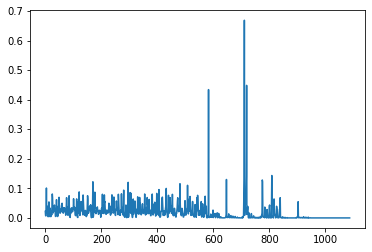

In [611]:
x = X_TRAIN[1144] 
for i, arr in enumerate(X_train_prepared):
      
    if np.array_equal(arr,_X  ):
        print(y[i])
        print(i)
      
plt.plot(_X   )

 
_X[0]